# Analysis of Traits Data (aka Fitting Models to Traits Data) <a class="tocSkip">

<!--NAVIGATION-->

<[Back to Workshop Contents](Index.ipynb)>

<div id="toc"> </div>

## Introduction

### Why traits?

A trait is any measurable feature of an individual organism. This includes physical traits (e.g., morphology, body mass, wing length), performance traits (e.g., respiration rate, body velocity, fecundity), and behavioral traits (e.g., feeding preference, foraging strategy, mate choice). All natural populations show variation in traits across individuals. A trait is functional when it directly (e.g., mortality rate) or indirectly (e.g., somatic development or growth rate) determines individual fitness. Therefore, variation in (functional) traits can generate variation in the rate of increase and persistence of populations. When measured in the context of life cycles, without considering interactions with other organisms (e.g., predators or prey of the vector), functional traits are typically called life history traits (such as mortality rate and fecundity). Other traits determine interactions both within the vector population (e.g., intraspecific interference or mating frequency) and between vectors and other species, including the species which may act as resources (prey, for example).

Thus both life history and interaction traits ultimately determine vector population [abundance](Abundances.ipynb), which ulimately influences disease transmission dynamics. Therefore, we will focus on traits in this section of the training workshop.

### Preliminaries

The following worked examples assume you have seen the [lectures](https://github.com/vectorbite/VBiTraining/tree/master/lectures).

You will need the `nls.lm` R package, which you can install using the standard method (linux users, launch R in `sudo` mode first):

```r
install.packages("minpack.lm") 
```

*Why `nls.lm`*? 
The standard NLLS function in R, cals `nls` uses a less robust algorithm called the Gauss-Newton algorithm. Therefore, `nls` will often fail to fit your model to the data if you start off at starting values for the parameters that are too far from what the optimal vaues would be, especially if the "parameter space" is weirdly shaped, i.e., the model has a mathematical form that makes it hard to find parameter combinations that minimize the NLLS. If this does not makes ense, don't worry about it- just go with `nls_LM` from the `nls.lm` package instead of `nls`! If you are really curious, try substituting `nls` for `nls_LM` in the examples below and compare the results. 

Later, you will also need the `R2jags` and `coda` R package for the Bayesian analysis section.

For starters, clear all variables and graphic devices and load necessary packages:

In [57]:
rm(list = ls())
graphics.off()
library("ggplot2")
library(repr)
options(repr.plot.width=6, repr.plot.height=5) # Change default plot size; not necessary if you are using Rstudio

Specifically for the NLLS section, we will also need to load the `minpack.lm` package:

In [58]:
require("minpack.lm") # for Levenberg-Marquardt nls fitting

## Model fitting using Non-linear least squares



### Allometric scaling of traits

Let's start with a common and reasonably simple example from biology: [allometric scaling](https://en.wikipedia.org/wiki/Allometry). We will look at allometric scaling of body weight vs. total body length in dragonflies and damselfiles. 

Allometric relationships take the form:

$$
y = a x^b
$$

where $x$ and $y$ are morphological measures (body length and body weight respectively, in our current example), the constant is the value of $y$ at body length $x = 1$ unit, and $b$ is the scaling "exponent". This is also called a power-law, because $y$ relates to $x$ through a simple power. 

First create a function object for the power law model:

In [59]:
powMod <- function(x, a, b) {
    return(a * x^b)
}

Now get the [data](https://raw.githubusercontent.com/mhasoba/TheMulQuaBio/master/Data/GenomeSize.csv) (first click on link and use "Save as" or `Ctrl+S` to download it as a csv). Then, save it in your `data` directory. After that, import it into your R workspace:

In [60]:
MyData <- read.csv("../data/GenomeSize.csv")

head(MyData)

Suborder,Family,Species,GenomeSize,GenomeSE,GenomeN,BodyWeight,TotalLength,HeadLength,ThoraxLength,AdbdomenLength,ForewingLength,HindwingLength,ForewingArea,HindwingArea,MorphologyN
Anisoptera,Aeshnidae,Aeshna canadensis,2.20,NA,1,0.159,67.58,6.83,11.81,48.94,45.47,45.40,369.57,483.61,2
Anisoptera,Aeshnidae,Aeshna constricta,1.76,0.06,4,0.228,71.97,6.84,10.72,54.41,46.00,45.48,411.15,517.38,3
Anisoptera,Aeshnidae,Aeshna eremita,1.85,NA,1,0.312,78.80,6.27,16.19,56.33,51.24,49.47,460.72,574.33,1
Anisoptera,Aeshnidae,Aeshna tuberculifera,1.78,0.10,2,0.218,72.44,6.62,12.53,53.29,49.84,48.82,468.74,591.42,2
Anisoptera,Aeshnidae,Aeshna umbrosa,2.00,NA,1,0.207,73.05,4.92,11.11,57.03,46.51,45.97,382.48,481.44,1
Anisoptera,Aeshnidae,Aeshna verticalis,1.59,NA,1,0.220,66.25,6.48,11.64,48.13,45.91,44.91,400.40,486.97,1


[Anisoptera](https://en.wikipedia.org/wiki/Dragonfly) are dragonflies, and [Zygoptera](https://en.wikipedia.org/wiki/Damselfly) are Damselflies. The variables of interest are `BodyWeight` and `TotalLength`.  Let's use the dragonflies data subset. 

So subset the data accordingly and remove NAs:

In [61]:
Data2Fit <- subset(MyData,Suborder == "Anisoptera")

Data2Fit <- Data2Fit[!is.na(Data2Fit$TotalLength),] # remove NA's

Plot it:

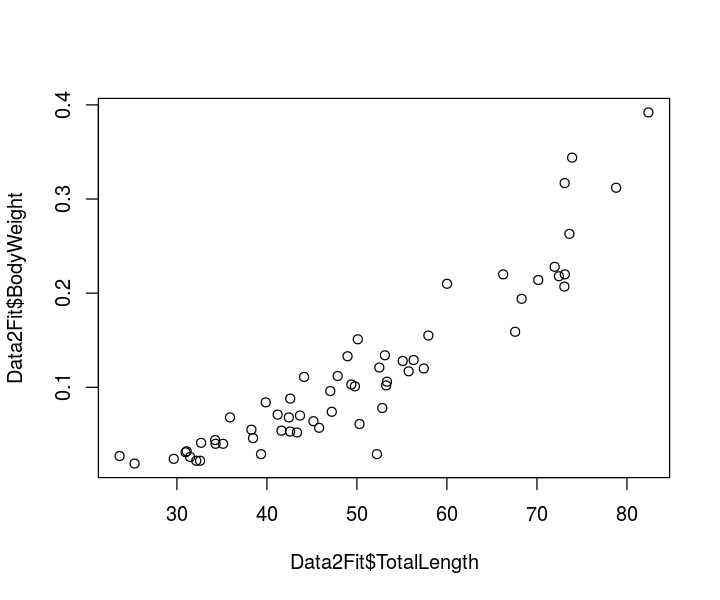

In [62]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)

Or better, using `ggplot`:

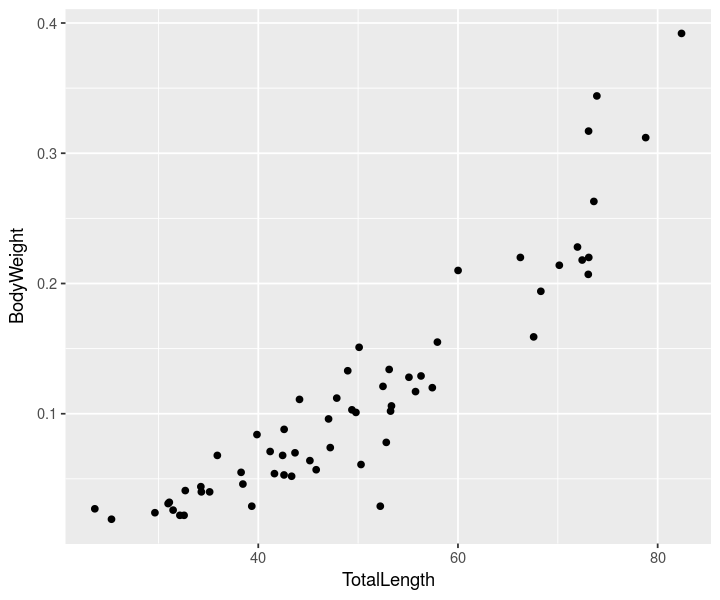

In [63]:
ggplot(Data2Fit, aes(x = TotalLength, y = BodyWeight)) + geom_point()

Now fit the model to the data using NLLS:

In [64]:
PowFit <- nlsLM(BodyWeight ~ powMod(TotalLength, a, b), data = Data2Fit, start = list(a = .1, b = .1))

We can use `summary()` just like we would for a `lm()` fit object. 

In [65]:
summary(PowFit)


Formula: BodyWeight ~ powMod(TotalLength, a, b)

Parameters:
   Estimate Std. Error t value Pr(>|t|)    
a 3.941e-06  2.234e-06   1.764    0.083 .  
b 2.585e+00  1.348e-01  19.174   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02807 on 58 degrees of freedom

Number of iterations to convergence: 39 
Achieved convergence tolerance: 1.49e-08


Most of the output is analogous to the output of an `lm()`. However, further statistucal inference here cannot be done using Analysis of Variance (ANOVA), because the mdoel is not a Linear Model. Try `anova(PowFit)`, and see what happens. The `Number of iterations to convergence`, and `Achieved convergence tolerance` stem from the fact that NLLS requires computer simulations; revisit the [Lecture](https://github.com/mhasoba/TheMulQuaBio/blob/master/Lectures/NLLS/Pawar_NLLS.pdf) for an explanation of this.

Now let's visualize the fit. For this, first we need to generate a vector of body lengths (the x-axis variable) for plotting: 

In [66]:
Lengths <- seq(min(Data2Fit$TotalLength),max(Data2Fit$TotalLength),len=200)

Next, calculate the predicted line. For this, we will need to extract the coefficient from the model fit object using the `coef()`command. 

In [67]:
coef(PowFit)["a"]
coef(PowFit)["b"]

a 
3.940685e-06

b 
2.585048

So, we can do the following:

In [68]:
Predic2PlotPow <- powMod(Lengths,coef(PowFit)["a"],coef(PowFit)["b"])

Now plot the data and the fitted model line:

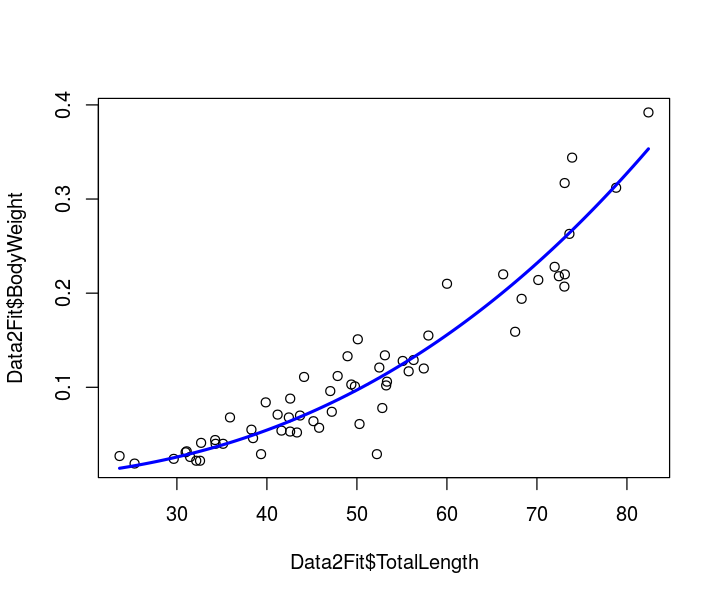

In [69]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)
lines(Lengths, Predic2PlotPow, col = 'blue', lwd = 2.5)

We can claculate the confidence intervals on the estimated parameters as we would in OLS fitting used for Linear Models: 

In [70]:
confint(PowFit)

Waiting for profiling to be done...


,2.5%,97.5%
a,1.171935e-06,1.205273e-05
b,2.318292e+00,2.872287e+00


As you likely have learnt before, a coefficient's CI should not include zero for it to be statistically significant (different from zero). 

### Exercises <a id='Allom_Exercises'></a>

(a) Make the same plot as above, fitted line and all, in `ggplot`, and add (display) the equation you estimated to your new (ggplot) plot. The equation is: $\text{Weight} = 3.94 \times 10^{-06} \times \text{Length}^{2.59}$

(b) Try playing with the starting values, and see if you can "break" the model fit -- that is the NLLS fitting does not converge on a solution.

(c) Repeat the model fitting (incuding a-b above) using the Zygoptera data subset.

   
(d) There is an alternative (and in fact, more commonly-used) approach for fitting the allometric model to data: using Oridinary Least Squares on bi-logarithamically transformed data. That is, if you take a log of both sides of the [allometric equation](#eq:allom) we get,

$$
\log(y) = \log(a) + b \log(x)
$$

This is a straight line equation of the form $c = d + b z $, where $c = \log(c)$, $d = \log(a)$, $z = \log(x)$, and $b$ is now the slope parameter. So you can use Ordinary Least Squares and the linear models framework (with `lm()`) in R to estimate the parameters of the allometric equation. 

In this exercise, try comparing the NLLS vs OLS methods to se how much difference you get in the parameter estimates between them. For example, see the methods used in this paper by [Cohen et al 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3465447/).

(e) The allometry between Body weight and Length is not the end of the story, you have a number of other linear morphological measurements (`HeadLength`, `ThoraxLength`, `AdbdomenLength`, `ForewingLength`, `HindwingLength`, `ForewingArea`, and `HindwingArea`) that can also be investigated. In this exercise, you will try two lines of investigation (again, repeated separately for Dragonflies and Damselfiles): 

  (i) How do each of these measurss allometrically scale with Body length (obtain estimates of scaling constant and exponent)? (Hint: you may want to use the `pairs()` command in R to get an overview of all the pairs of potential scaling relationships. 

  (ii) Do any of the linear morphological measurements other than body length better predict Body weight? That is, does body weight scale more tightly with a linear morphological measurement other than total body length? 

### Comparing models

*How do we know that there isn't a better or alternative model that adequately explains the pattern in your dataset?* 

This is important consideration in all data analyses (and more generally, the scientific method!), so you must aim to compare your NLLS model with an one or more alternatives for a more extensive and reliable investigation of the problem. 

Let's use  model comparison to investigate whether the relationship between body weight and length we found above is indeed allometric. For this, we need an alternative model that can be fitted to the same data. Let's try a quadratic curve, which is of the form:

$$y = a + b x + c x^2$$

This can also capture curvature in data, just as the [allometric equation](#eq:allom). Note that this mode is linear in its parameters (a linear model), which You can fit to the simply data using your favorite `lm()` function:   

In [71]:
QuaFit <- lm(BodyWeight ~ poly(TotalLength,2), data = Data2Fit)

And like before, we obtain the predicted values (but this time using the `predict.lm` function):

In [72]:
Predic2PlotQua <- predict.lm(QuaFit, data.frame(TotalLength = Lengths))

Now let's plot the two fitted models together:

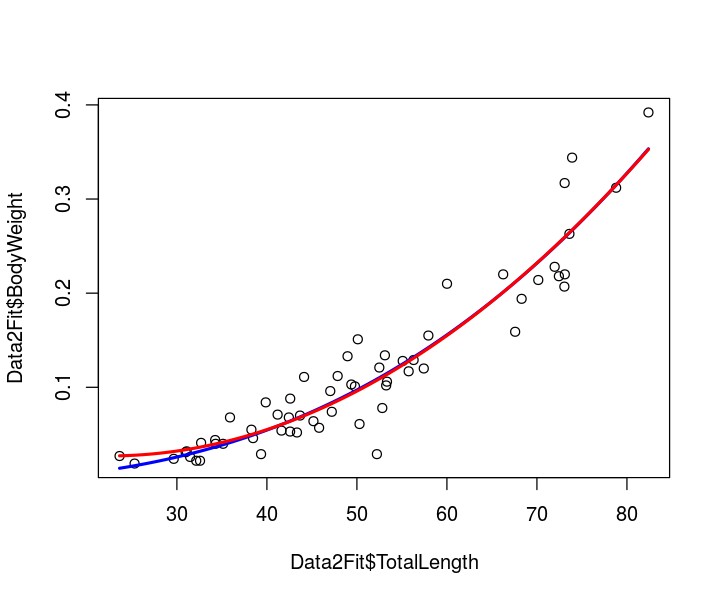

In [73]:
plot(Data2Fit$TotalLength, Data2Fit$BodyWeight)
lines(Lengths, Predic2PlotPow, col = 'blue', lwd = 2.5)
lines(Lengths, Predic2PlotQua, col = 'red', lwd = 2.5)

Very similar fits, except that the quadratic model seems to get it wrong at the lower end of the data range. Let's do a proper/formal model comparison now to check which model better-fits the data.

Let's first calculate the R$^2$ values of the two fitted models:

In [74]:
RSS_Pow <- sum(residuals(PowFit)^2)  # Residual sum of squares
TSS_Pow <- sum((Data2Fit$BodyWeight - mean(Data2Fit$BodyWeight))^2)  # Total sum of squares
RSq_Pow <- 1 - (RSS_Pow/TSS_Pow)  # R-squared value

RSS_Qua <- sum(residuals(QuaFit)^2)  # Residual sum of squares
TSS_Qua <- sum((Data2Fit$BodyWeight - mean(Data2Fit$BodyWeight))^2)  # Total sum of squares
RSq_Qua <- 1 - (RSS_Qua/TSS_Qua)  # R-squared value

RSq_Pow 
RSq_Qua

[1] 0.9005475

[1] 0.9003029

Not very useful. In general, R$^2$ is a good measure of model fit, but cannot be used for model selection -- epecially not here, given the tiny difference in R$^2$'s.

Instead, as discussed in the [lecture](), we can use the Akaike Information Criterion (AIC):

In [75]:
n <- nrow(Data2Fit) #set sample size
kPow <- length(coef(PowFit)) # get number of parameters in power law model
kQua <- length(coef(QuaFit)) # get number of parameters in quadratic model

AIC_Pow <- n * log((2 * pi) / n) + n + 2 + n * log(RSS_Pow) + 2 * kPow
AIC_Qua <- n * log((2 * pi) / n) + n + 2 + n * log(RSS_Qua) + 2 * kQua
AIC_Pow - AIC_Qua

[1] -2.147426

Of course, as you might have suspected, we can do this using an in-built function in R! 

In [76]:
AIC(PowFit) - AIC(QuaFit)

[1] -2.147426

*So which model wins?* As we had dicussed in the NLLS lecture, a rule of thumb is that a AIC value difference (typically denoted as $\Delta$AIC) > 2 is a acceptable cutoff for calling a winner. So the power law (allometric model) is a better fit here. Read the [Johnson & Omland paper](https://github.com/mhasoba/TheMulQuaBio/blob/master/Readings/Modelling/JohnsonOmland2004.pdf) for more on model selection in Ecology and Evolution.    

### Exercises <a id='ModelSelection_Exercises'></a>

(a) Calculate the Bayesian Information Criterion (BIC), also know as the Schwarz Criterion (see your Lecture notes and the [Johnson & Omland paper](https://github.com/mhasoba/TheMulQuaBio/blob/master/Readings/Modelling/JohnsonOmland2004.pdf), and use $\Delta$BIC to select the better fitting model. 

(b) Fit a straight line to the same data and compare with the allometric and quadratic models.

(c) Repeat the model comparison (incuding 1-2 above) using the Damselflies (Zygoptera) data subset -- does the allometric mdoel still win?

(d) Repeat exercise (e)(i) and (ii) from the [above set](#Allom_Exercises), biut with model comparison (e.g., again using a quadratic as a alternative model) to establish that the relationships are indeed allometric.

### Albatross chick growth

Now let's look at a different trait example: the growth of an individual. First load and plot the data:

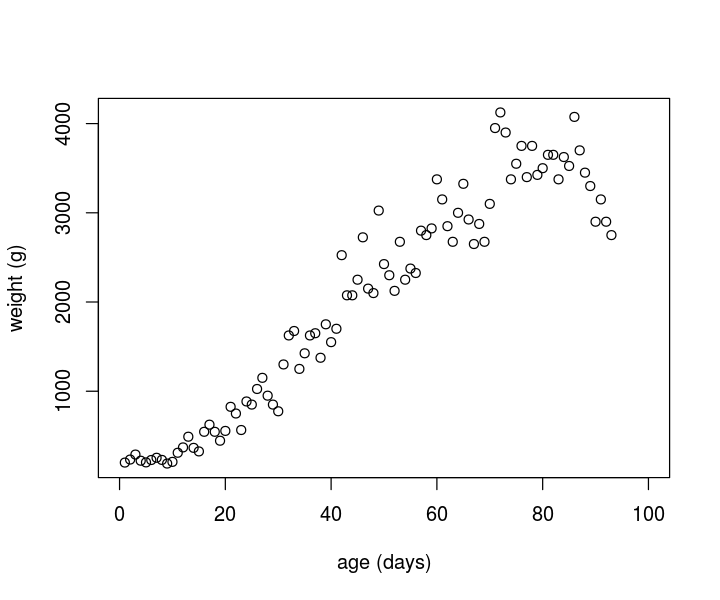

In [77]:
alb<-read.csv(file="../data/albatross_grow.csv")
alb<-subset(x=alb, !is.na(alb$wt))
plot(alb$age, alb$wt, xlab="age (days)", ylab="weight (g)", xlim=c(0, 100))

#### Fitting three curves using NLS

Let's fit multiple mdoels to this dataset.

The Von Bertalanffy model is commonly used for modelling the growth of an individual. It's formulation is:
$$
W(t) = \rho (L_{\infty}(1-e^{-Kt})+L_0 e^{-Kt})^3
$$
If we pull out $L_{\infty}$ and define $c=L_0/L_{\infty}$ and $W_{\infty}=\rho L_{\infty}^3$ this equation becomes:
$$
W(t) = W_{\infty}(1-e^{-Kt}+ c e^{-Kt})^3.
$$
$W_{\infty}$ is interpreted as the mean asymptotic weight, and $c$ the ratio between the initial and final lengths. This second equation is the one we will fit.

We will compare this model against the classical Logistic growth equation, and a straight line. First, as we did before, let's define the R functions for the two models:

In [78]:
logistic1<-function(t, r, K, N0){
  N0*K*exp(r*t)/(K+N0*(exp(r*t)-1))
}

vonbert.w<-function(t, Winf, c, K){
  Winf*(1 - exp(-K*t) + c*exp(-K*t))^3
}

For the straight line, we use simply use R's `lm()` function, as that is a linear least squares problem. Using NLLS will give (approximately) the same answer, of course. Now fit all 3 models using least squares. 

We will scale the data before fitting to improve the stability of the estimates:

In [79]:
scale<-4000

alb.lin<-lm(wt/scale~age, data=alb)

In [80]:
alb.log<-nlsLM(wt/scale~logistic1(age, r, K, N0), start=list(K=1, r=0.1, N0=0.1), data=alb)

alb.vb<-nlsLM(wt/scale~vonbert.w(age, Winf, c, K), start=list(Winf=0.75, c=0.01, K=0.01), data=alb)

Next let's calculate predictions for each of the models across a range of ages.

In [81]:
ages<-seq(0, 100, length=1000)

pred.lin<-predict(alb.lin, newdata = list(age=ages))*scale

pred.log<-predict(alb.log, newdata = list(age=ages))*scale

pred.vb<-predict(alb.vb, newdata = list(age=ages))*scale

And finally plot the data with the fits:

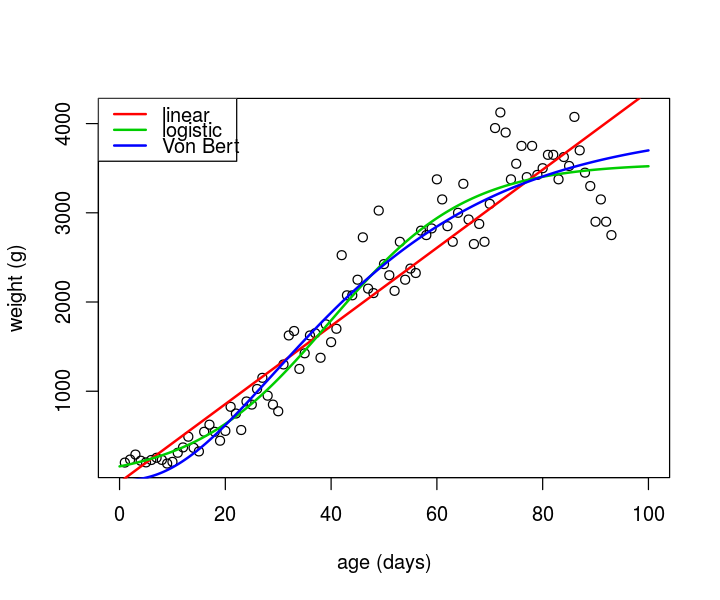

In [82]:
plot(alb$age, alb$wt, xlab="age (days)", ylab="weight (g)", xlim=c(0,100))
lines(ages, pred.lin, col=2, lwd=2)
lines(ages, pred.log, col=3, lwd=2)
lines(ages, pred.vb, col=4, lwd=2)

legend("topleft", legend = c("linear", "logistic", "Von Bert"), lwd=2, lty=1, col=2:4)

Next examine the residuals between the 3 models:

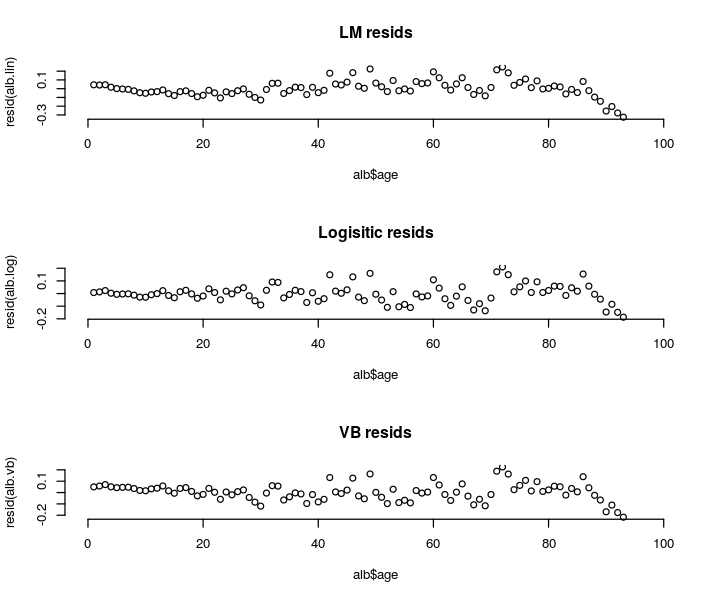

In [83]:
par(mfrow=c(3,1), bty="n")
plot(alb$age, resid(alb.lin), main="LM resids", xlim=c(0,100))
plot(alb$age, resid(alb.log), main="Logisitic resids", xlim=c(0,100))
plot(alb$age, resid(alb.vb), main="VB resids", xlim=c(0,100))

The residuals for all 3 models still exhibit some patterns. In particular, the data seems to go down near the end of the observation period, but none of these models can capture that behavior. 

Finally, let's compare the 3 models using a simpler approach than the AIC/BIC one that  we used [above](#):

In [84]:
n<-length(alb$wt)
list(lin=signif(sum(resid(alb.lin)^2)/(n-2*2), 3), 
    log= signif(sum(resid(alb.log)^2)/(n-2*3), 3), 
    vb= signif(sum(resid(alb.vb)^2)/(n-2*3), 3))          

$lin
[1] 0.00958

$log
[1] 0.0056

$vb
[1] 0.00628

The logistic model has the lowest adjusted SSE, so it's the best by this measure. It is also, visually, a better fit. 

### Excercises <a id='Albatross_Exercises'></a>

(a) Use AIC/BIC to perform model selection on the Albatross data as we did for the trait allometry example.

(b) Write this example as a self-sufficient R script, with ggplot istead of base plotting 

### Aedes aegypti fecundity

Now let's actually look at a disease vector example! These data measure the reponse of *Aedes aegypti* fecundity to temperature. 

First load and visualize the data:

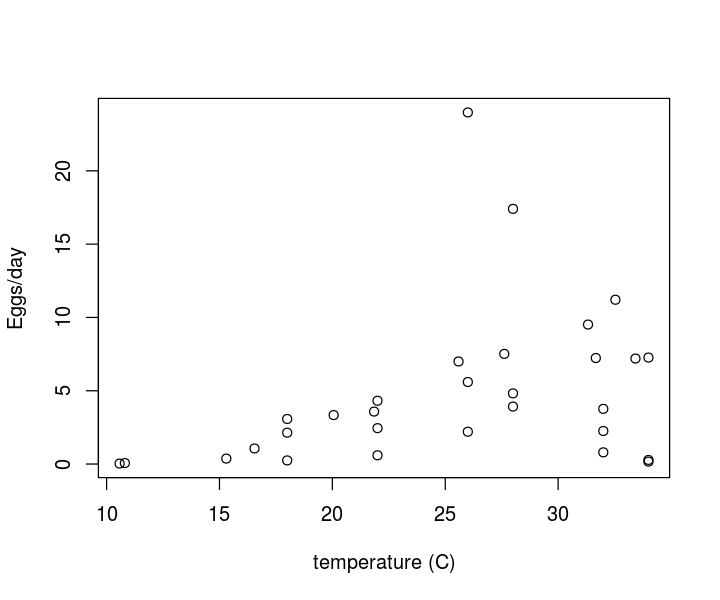

In [85]:
aedes<-read.csv(file="../data/aedes_fecund.csv")

plot(aedes$T, aedes$EFD, xlab="temperature (C)", ylab="Eggs/day")

### Fitting models

Let's define some models first:

In [86]:
quad1<-function(T, T0, Tm, c){
  c*(T-T0)*(T-Tm)*as.numeric(T<Tm)*as.numeric(T>T0)
}

briere<-function(T, T0, Tm, c){
  c*T*(T-T0)*(abs(Tm-T)^(1/2))*as.numeric(T<Tm)*as.numeric(T>T0)
}

Instead of using the inbuilt quadratic function in R, we we define our own to make it easier to choose starting values, and so that we can force the function to be equal to zero above and below the minimum and maximum temperature thresholds (more on this below). The Briere function is a commonly used model for tempoeratuire dependence of insect traits. As in the case of the albatross growth data, we will also compare these two with a strauight line (again, its a linear model, so we can just use `lm()` without needing to define a function for it). 

Now fit all 3 models using least squares. Although it's not as necessary here (as the data don't have as large values as the albatross example), we will again scale the data first: 

In [87]:
scale<-20

aed.lin<-lm(EFD/scale~T, data=aedes)

aed.quad<-nlsLM(EFD/scale~quad1(T, T0, Tm, c), start=list(T0=10, Tm=40, c=0.01), data=aedes)

aed.br<-nlsLM(EFD/scale~briere(T, T0, Tm, c), start=list(T0=10, Tm=40, c=0.1), data=aedes)

### Exercises <a id='Aedes_Exercises'></a>

(a) Complete the *Aedes* data analysis by fitiing model, calculating predictions and then comparing models. Write a single, self-standing script for it. Which model fits best? By what measure?

(b) In this script, use ggplot instead of base plotting.

## Model fitting using Maximum Likelihood

Above we learned how to fit a mathematical model/equation to data by using the Least Squares method (linear or nonlinear). That is, we choose the parameters of model being fitted (e.g., straight line) to minimize the sum of the squares of the residuals/errors sround the fitted model. An alternative to minimizing the sum of squared errors is to find parameters to the function such that the *likelihood* of the parameters, given the data and the model, is maximized. Please see the [lectures](https://github.com/vectorbite/VBiTraining/tree/master/lectures) for the theoretical background to the following R examples.

We will first implement the (negative log) likelihood for simple linear regression (SLR) in R. Recall that SLR assumes every observation in the dataset was generated by the model:

$$
Y_i = \beta_0 + \beta_1 X_i + \varepsilon_i, \;\;\; \varepsilon_i \stackrel{\mathrm{iid}}{\sim} \mathrm{N}(0, \sigma^2)
$$

That is, this is a model for the *conditional distribution* of $Y$ given $X$. The pdf for the normal distribution is given by

$$
f(x) = \frac{1}{\sqrt{2\sigma^2 \pi}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2} \right)
$$

In the SLR model, the conditional distribution has *this* distribution. 

That is, for any single observation, $y_i$
$$
f(y_i|\beta_0, \beta_1, x_i) = \frac{1}{\sqrt{2\sigma^2 \pi}} \exp\left(-\frac{(y_i-(\beta_0+\beta_1 x_i))^2}{2\sigma^2} \right)
$$

Interpreting this function as a function of the parameters $\theta=\{ \beta_0, \beta_1, \sigma \}$, then it gives us the likelihood of the $i^{\mathrm{th}}$ data point. 

As we did for the simple binomial distribution (see [lecture](https://github.com/vectorbite/VBiTraining/tree/master/lectures)), we can use this to estimate the parameters of the model.

### Implementing the Likelihood in R

First, we need to build an R function that returns the (negative log) likelihood for SLR (it is negative log because the log of likelihood is itself negative):

In [88]:
nll.slr <- function(par, dat, ...){
  args <- list(...)
  
  b0 <- par[1]
  b1 <- par[2]
  X <- dat$X
  Y <- dat$Y
  if(!is.na(args$sigma)){
      sigma <- args$sigma
  } else 
      sigma <- par[3]

  mu <- b0+b1*X
  
  return(-sum(dnorm(Y, mean=mu, sd=sigma, log=TRUE)))
}

Note that we do something a bit different here (the "`...`" bit). We do it this way because we want to be able to use R's `optim()` function later.

The `dnorm()` function calculates the logged (the `log=TRUE` argument) probability of observing Y given mu, sigma and that X.  

The negative sign on `sum()` is because the `optim()` function in R will minimize the negative log-likelihood, which is a sum: Recall that The log-likelihood of the parameters $\theta$ being true given data x equals to the sum of the logged probability densities of observing the data x given parameters $\theta$. We want to maximize this (log-) likelihood using `optim()`.

Let's generate some simulated data, assuming that: $\beta_0=$ `b0`, $\beta_1=$ `b1`, and $\sigma=$ `sigma`. For this, we will generate random deviations to simulate sampling or measurement error around an otherwise perfect line of data values:

In [89]:
set.seed(123)
n <- 30
b0 <- 10
b1 <- 3
sigma <- 2
X <- rnorm(n, mean=3, sd=7)
Y <- b0 + b1*X + rnorm(n, mean=0, sd=sigma)
dat <- data.frame(X=X, Y=Y) # convert to a data frame

In the first line, we `set.seed()` to ensure that we can reproduce the results. The seed number you choose is the starting point used in the generation of a sequence of random numbers. No plot the "data":

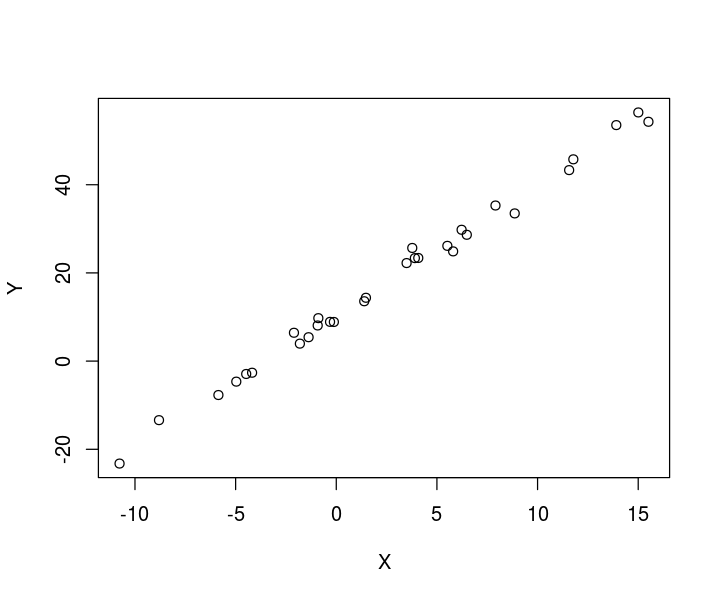

In [90]:
plot(X, Y)

### Likelihood profile in R

For now, let's assume that we know what $\beta_1$ is. Let's build a likelihood profile for the simulated data:

In [91]:
N <- 50
b0s <- seq(5, 15, length=N)
mynll <- rep(NA, length=50)
for(i in 1:N){
  mynll[i] <- nll.slr(par=c(b0s[i],b1), dat=dat, sigma=sigma)
}

That is, we calculate the negative log-likelihood for fixed b1, across a range (5 - 15) of b0.  

Now plot the profile:

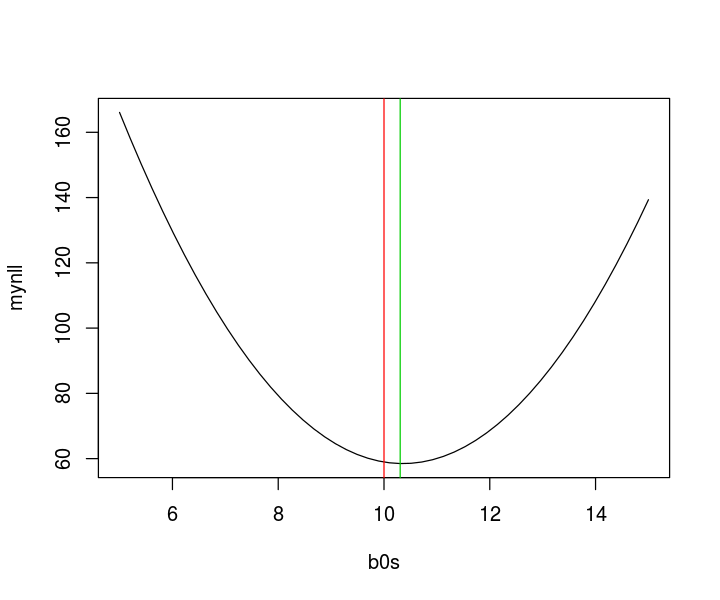

In [92]:
plot(b0s, mynll, type="l")
abline(v=b0, col=2)
abline(v=b0s[which.min(mynll)], col=3)

The true value for b0 (10) is the red line, while the value that minimizes the log-likelihood (i.e., maximizes the negative log-likelihood) is the green line. These are not the same because maximum likelihood is providing an *estimate* of the true value given the measurement errors (that we ourselves generated in tgis synthetic dataset).  

### Likelihood surface in R

If we wanted to estimate both $\beta_0$ and $\beta_1$ (two parameters), we need to deal with a two-dimensional maximum likelihood surface. The simplest approach is to do a *grid search* to find this  likelihood surface.

10.00000,3.00
10.48485,2.96


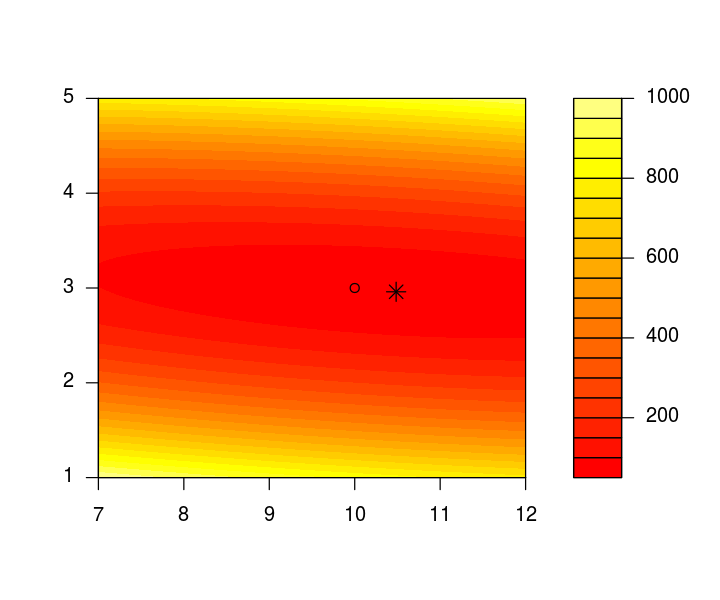

In [93]:
N0 <- 100
N1 <- 101
b0s <- seq(7,12, length=N0)
b1s <- seq(1,5, length=N1)

mynll<-matrix(NA, nrow=N0, ncol=N1)
for(i in 1:N0){
  for(j in 1:N1) mynll[i,j]<-nll.slr(par=c(b0s[i],b1s[j]), dat=dat, sigma=sigma)
}

ww <- which(mynll==min(mynll), arr.ind=TRUE)

b0.est <- b0s[ww[1]]
b1.est <- b1s[ww[2]]
rbind(c(b0, b1), c(b0.est, b1.est))

filled.contour(x = b0s, y = b1s, z= mynll, col=heat.colors(21), 
               plot.axes = {axis(1); axis(2); points(b0,b1, pch=21); 
                            points(b0.est, b1.est, pch=8, cex=1.5); xlab="b0"; ylab="b1"})

There is a lot going on here. Make sure you ask one of us if some of the code does not make sense!

Again, note that the true parameter combination (asterisk) and the one what maximizes the negative log-likelihood (circle) are different.

#### Conditional Likelihood
We can also look at the conditional surfaces (i.e., we look at the slice around whatever the best estimate is for the other parameter):

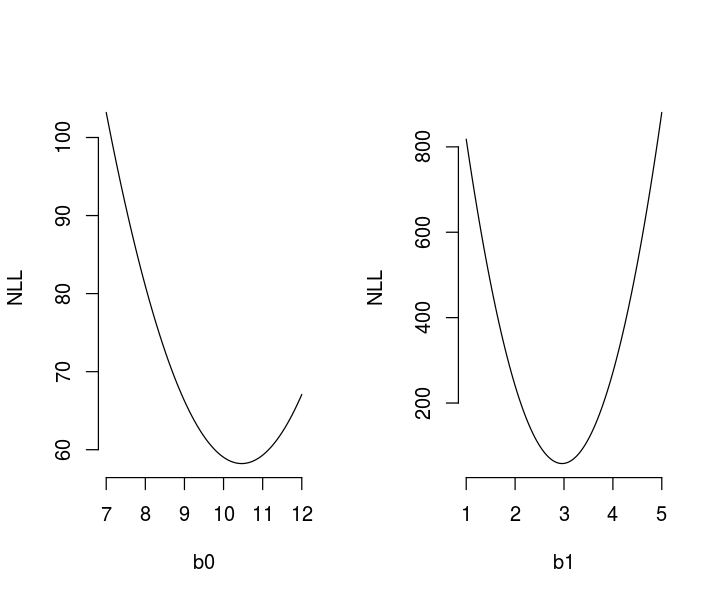

In [94]:
par(mfrow=c(1,2), bty="n")
plot(b0s, mynll[,ww[2]], type="l", xlab="b0", ylab="NLL")
plot(b1s, mynll[ww[1],], type="l", xlab="b1", ylab="NLL")

### Alternatives to Grid Search

There are many alternative methods to grid searches. Since we are seeking to minimize an arbitrary function (the negative log likelihood) we typically use a descent method to perform general optimization.

There are lots of options implemented in the `optim`function in R. We won't go into the details of these methods, due to time constraints. However, typically one would most commonly use:

* Brent's method: for 1-D search within a bounding box, only
* L-BFGS-B (limited-memory Broyden–Fletcher–Goldfarb–Shanno algorithm with bounding box constraints): a quasi-Newton method, used for higher dimensions, when you want to be able to put simple limits on your search area.  
 

### Maximum Likelihood using optim()

We can now do the fitting. This involves optimization (to find the appropriate parameter values that achieve the maximum of the likelihood surface above). For this, we will use R's versatile `optim()` function.

The first argument for `optim()` is the function that you want to minimize, and the second is a vector of starting values for your parameters (as always, do a`?optim`). After the main arguments, you can add what you need to evaluate your function (e.g. `sigma` ). The addtional argument sigma can be "fed" to `nll.slr` because we use the `...` convention when defining it.

In [95]:
fit <- optim(nll.slr, par=c(2, 1), method="L-BFGS-B", ## this is a n-D method
              lower=-Inf, upper=Inf, dat=dat, sigma=sigma)

fit

$par
[1] 10.458935  2.961704

$value
[1] 58.22473

$counts
function gradient 
      12       12 

$convergence
[1] 0

$message
[1] "CONVERGENCE: REL_REDUCTION_OF_F <= FACTR*EPSMCH"

Easy as pie (once you have the recipe)! We can also fit sigma as the same time if we want:

In [96]:
fit <- optim(nll.slr, par=c(2, 1, 5), method="L-BFGS-B", ## this is a n-D method
              lower=c(-Inf, -Inf, 0.1), upper=Inf, dat=dat, sigma=NA)
fit$par

[1] 10.458945  2.961704  1.621689

The starting values (b0 = 2, b1  = 1, sigma = 5) need to be assigned as we would do for NLLS. Also note that much like NLLS, we have bounded the parameters. The exact starting values are not too important in this case (try changing them see what happens).

Now visualize the fit:

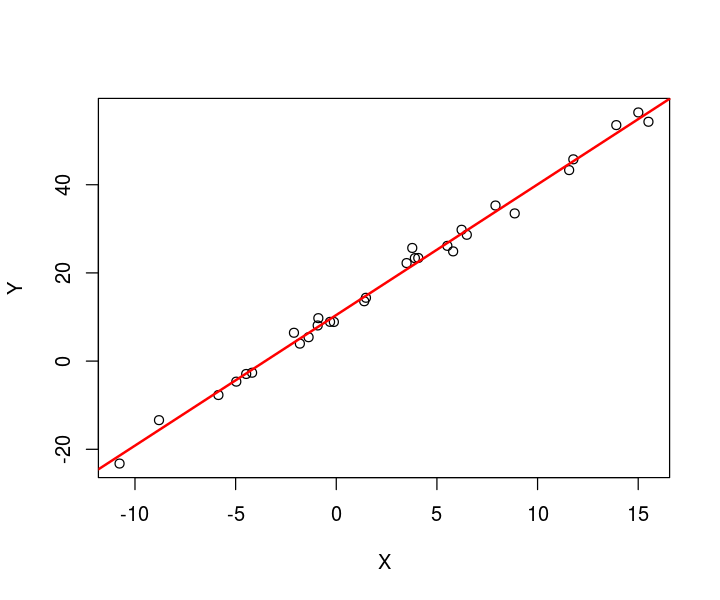

In [97]:
plot(X, Y)
abline(a=fit$par[1], b=fit$par[2], col=2, lwd=2)

### Confidence intervals

The joint distribution of the MLEs are asymptotically Normally distributed. Given this, if you are minimizing the negative log likelihood (NLL) then the covariance matrix of the estimates is (asymptotically) the inverse of the Hessian matrix. The Hessian matrix evalutes the second derivatives of the NLL (numerically here), which gives us information about the curvature the likelihood. Thus we can use the Hessian to estimate confidence intervals:

In [98]:
fit <- optim(nll.slr, par=c(2, 1), method="L-BFGS-B", hessian=TRUE, lower=-Inf, upper=Inf, dat=dat, sigma=sigma)

fisher_info<-solve(fit$hessian)
est_sigma<-sqrt(diag(fisher_info))
upper<-fit$par+1.96*est_sigma
lower<-fit$par-1.96*est_sigma
interval<-data.frame(value=fit$par, upper=upper, lower=lower)
interval

value,upper,lower
10.458935,11.228565,9.689305
2.961704,3.067705,2.855704


### Comparison to fitting with least squares

We can, of course, simply fit the model with lest squares using the `lm()` function:

In [99]:
lmfit<-lm(Y~X)

summary(lmfit)$coeff

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),10.458936,0.32957007,31.73509,1.699822e-23
X,2.961704,0.04539126,65.24834,3.874555e-32


The estimates we get using `optim()` are almost identical to the estimates that we obtain here, and the standard errors on the intercept and slope are very similar to those we calculated from the Hessian (est_sigma= `r est_sigma`). 

### Model Selection

You can use [AIC or BIC as you did in NLLS](#Comparing-models) using the likelihood you have calculated. 

You can also use the Likelihood Ratio Test (LRT).

### Exercises <a id='MLE_Exercises'></a> 

Try MLE fitting for the allometric trait data example [above](#Allometric-scaling-of-traits). You will use the same data + functions that you used to practice fitting curves using non-linear least squares methods. You have two options here. The easier one is to convert the power law model to a straight line model by taking a log (explained the Allometry [Exercises](#Allom_Exercises). Specifically,

(a) Using the [`nll.slr`](#Implementing-the-Likelihood-in-R) function as an example, write a function that calculates the negative log likelihood as a function of the parameters describing your trait and any additional parameters you need for an appropriate noise distribution (e.g., $\sigma$ if you have normally distributed errors).

(b) For at least one of your parameters plot a likelihood profile given your data, with the other parametes fixed.

(c) Use the `optim` function to find the MLE of the same parameter and indicate this on your likelihood profile.

(d) Obtain a confidence interval for your estimate.

A more challenging option is to fit the allometry data directly to the power law equation. You would need to assume a log-normal distribution for the errors instead of normal, in this case.   

## Fitting Models the Bayesian way 

Recall from the [lectures](https://github.com/vectorbite/VBiTraining/tree/master/lectures) that for Bayesian model fitting/inference, we need to: 


1. **Assess MCMC convergence**: MCMC is family of algorithm for sampling probability distributions so that it can be adequately characterized (in the Bayesian context the posterior distribution). The MCMC procedure reaches *convergence* once we have sufficient random draws from the posterior distribution. To assess convergence we look at trace plots. The goal is to get "fuzzy caterpillars"-looking curves. 

2. **Summarize MCMC draws**: Summarize and visualize outcome of the random draws using histograms for all draws for each parameter, and calculate expectation, variance, credibility interval, etc.

3. **Prior Sensitivity**: Assess prior sensitivity by changing prior values and check whether it affects the results or not. If it does, that means that the results are too sensitive to that prior, not good!

4. **Make inferences**: We use the values from item (2) to make inferences and answer the research question.

### Midge wing lengths

We will use a simple example to go through the steps of Bayesian model fitting and inference. First load the `rjags` package: 

In [100]:
library(rjags)

Loading required package: coda
Linked to JAGS 4.2.0
Loaded modules: basemod,bugs


#### The Data

Grogan and Wirth (1981) provide data on the wing length in millimeters of nine members of a species of midge (small, two-winged flies). From these measurements, let's make a Bayesian inference about the population's mean ($\mu$).

First's load the data (by now, you must have become used to grabbing data from the appropriate directory of this workshop's [git repository](https://github.com/vectorbite/VBiTraining)! ):

In [101]:
WL.data<-read.csv("../data/MidgeWingLength.csv")
Y <- WL.data$WingLength
n <- length(Y)

Visualize the data: 

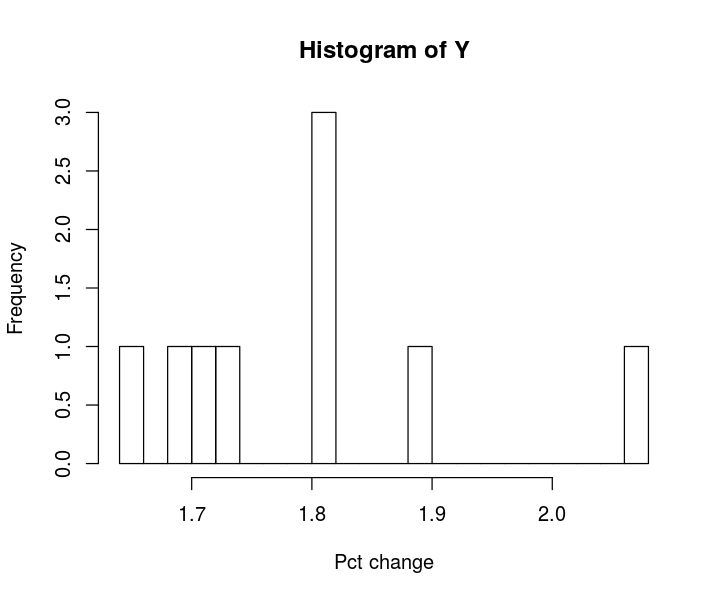

In [102]:
hist(Y,breaks=20,xlab="Pct change") 

#### The Prior Information

Studies from other populations suggest that wing lengths are usually around 1.9mm, so we set $\mu_0 = 1.9$. We also know that lengths must be positive ($\mu >0$).

We can impose these conditions with a normal prior distribution for $\mu$ as follows. 

Since most of the normal density is within two standard deviations from the mean, we choose $\tau^2_0$ so that

$$ \mu_0 - 2\tau_0 >0 \Rightarrow \tau_0 <1.2/2 = 0.95 $$

To keep it simple we choose the variance $\sigma^2$ to follow the inverse gamma distribution, meaning that $1/\sigma^2$ follows a gamma distribution with $ a = b = 0.01$. As a result, our prior is a conjugate prior and the posterior is a normal distribution as well.

Now assign some values for the moments and other parameters

In [103]:
mu0 <- 1.9
s20 <- 0.8
a   <- 0.01
b   <- 0.01

Next, for rjags, we need to create the function as a string : 

In [104]:
model1 <- "model{
  for(i in 1:n){ # The Likelihood
    Y[i] ~ dnorm(mu,inv.var)
  }

  # Prior for mu
  mu ~ dnorm(mu0,inv.var0)
  inv.var0 <- 1/s20

  # Prior for the inverse variance
  inv.var   ~ dgamma(a, b)

  # Compute the variance
  s2 <- 1/inv.var
}"

Now fit it in RJags:

In [105]:
model <- jags.model(textConnection(model1), 
                    n.chains = 3,
                    data = list(Y=Y,n=n,mu0=mu0,s20=s20,a=a,b=b))

update(model, 10000, progress.bar="none"); # Burnin for 10000 samples

samp <- coda.samples(model, 
        variable.names=c("mu","s2"), 
        n.iter=20000, progress.bar="none")

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 9
   Unobserved stochastic nodes: 2
   Total graph size: 21

Initializing model



Now we will go through the Bayesian fitting/inference steps. 

#### Assessing Convergence by looking at trace plots

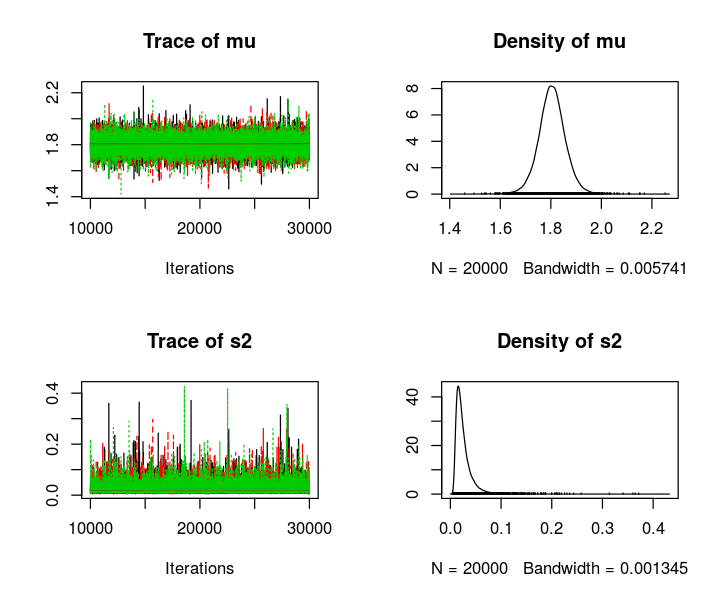

In [106]:
plot(samp)

#### Summarize  MCMC draws 

In [107]:
summary(samp)


Iterations = 10001:30000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean     SD  Naive SE Time-series SE
mu 1.80461 0.0532 2.172e-04      2.165e-04
s2 0.02573 0.0180 7.348e-05      8.599e-05

2. Quantiles for each variable:

       2.5%     25%     50%     75%   97.5%
mu 1.699330 1.77177 1.80430 1.83729 1.91040
s2 0.008879 0.01509 0.02103 0.03044 0.07018


#### Assess Prior Sensitivity

Try different prior parameter and check your results:

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 9
   Unobserved stochastic nodes: 2
   Total graph size: 21

Initializing model



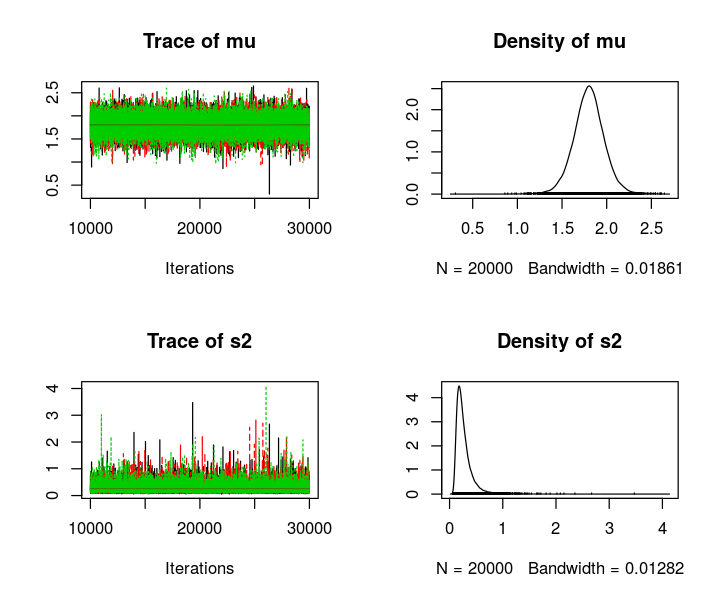

In [108]:
mu0 <- 0
s20 <- 10
a   <- 1
b   <- 1

model2 <- "model{

  # Likelihood
  for(i in 1:n){
    Y[i] ~ dnorm(mu,inv.var)
  }

  # Prior for mu
  mu        ~ dnorm(mu0,inv.var0)
  inv.var0 <- 1/s20

  # Prior for the inverse variance
  inv.var   ~ dgamma(a, b)

  # Compute the variance
  s2       <- 1/inv.var
}"

model <- jags.model(textConnection(model2), 
                    n.chains = 3,
                    data = list(Y=Y,n=n,mu0=mu0,s20=s20,a=a,b=b))
update(model, 10000, progress.bar="none"); # Burnin for 10000 samples

samp <- coda.samples(model, 
        variable.names=c("mu","s2"), 
        n.iter=20000, progress.bar="none")

plot(samp)

In [109]:
summary(samp)


Iterations = 10001:30000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 20000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

     Mean     SD  Naive SE Time-series SE
mu 1.7998 0.1708 0.0006975      0.0007024
s2 0.2662 0.1542 0.0006295      0.0006969

2. Quantiles for each variable:

    2.5%    25%    50%    75%  97.5%
mu 1.460 1.6936 1.8004 1.9060 2.1420
s2 0.104 0.1696 0.2276 0.3159 0.6587


#### Make the Inference

Now we can use values from our summary to answer our research question. 

For example, given the data, we can predict that the expected midge wing length is $E(\mu|\tilde{Y}) =1.8$mm with variance $V(\mu|\tilde{Y}) =0.05^2$.

### Aedes revisited using Bayesian fitting

Now let's do some Bayesian model fitting to *Aedes* thermal performance data. 

In [110]:
require(R2jags) # fitting
require(coda) # diagnostic plots
set.seed(1234)

Loading required package: R2jags

Attaching package: ‘R2jags’

The following object is masked from ‘package:coda’:

    traceplot



Load the data:

In [111]:
Aaeg.data <- read.csv("../data/AeaegyptiTraitData.csv")

#### The Data

These data are traits from *Aedes aegypti* mosquitoes measured across temperature in lab experiments. The traits we have data on thermal performance are:
- pEA: proportion surviving from egg to adulthood  
- MDR: mosquito development rate  
- PDR: parasite development rate (= 1/EIP the extrinsic incubation period)  
- $\mu$ (mu): death rate (= 1/longevity)  

Note that some of the traits come in multiple forms (e.g., $\mu$ and 1/$\mu$, PDR and EIP).

Have a look at the data:

In [112]:
head(Aaeg.data)

trait.name,T,trait,ref,trait2,trait2.name
pEA,22,0.90812,Westbrook_Thesis_2010,NA,NA
pEA,27,0.93590,Westbrook_Thesis_2010,NA,NA
pEA,32,0.81944,Westbrook_Thesis_2010,NA,NA
MDR,22,0.09174,Westbrook_Thesis_2010,NA,NA
MDR,27,0.13587,Westbrook_Thesis_2010,NA,NA
MDR,32,0.15823,Westbrook_Thesis_2010,NA,NA


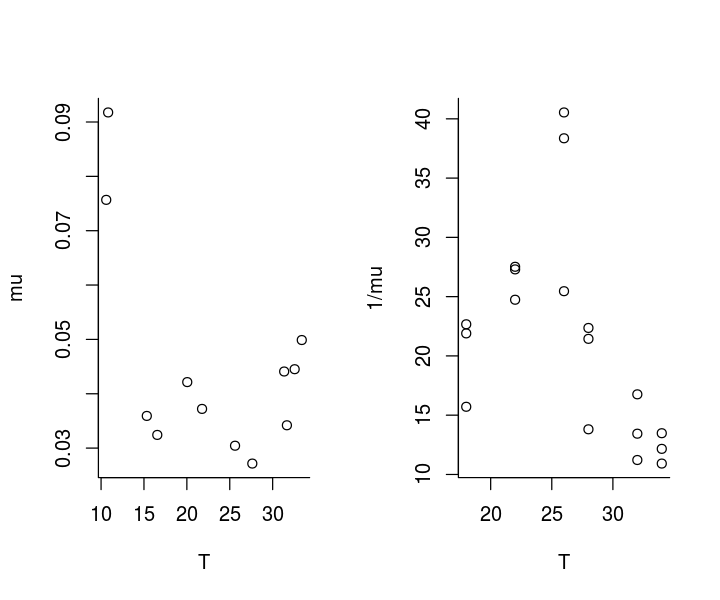

In [113]:
mu.data <- subset(Aaeg.data, trait.name == "mu")
lf.data <- subset(Aaeg.data, trait.name == "1/mu")
par(mfrow=c(1,2), bty="l") 
plot(trait ~ T, data = mu.data, ylab="mu")
plot(trait ~ T, data = lf.data, ylab="1/mu")

Note that the $\mu$ data is u-shaped and the lifespan data is unimodal (hump-shaped).  

Since thermal biology theory is based on unimodal thermal responses, we want to fit the trait as lifespan instead of $\mu$. Thus, we'll need to convert the $\mu$ data to lifespan by taking the inverse. The combined data should have a nice unimodal shape that we can fit a function to:

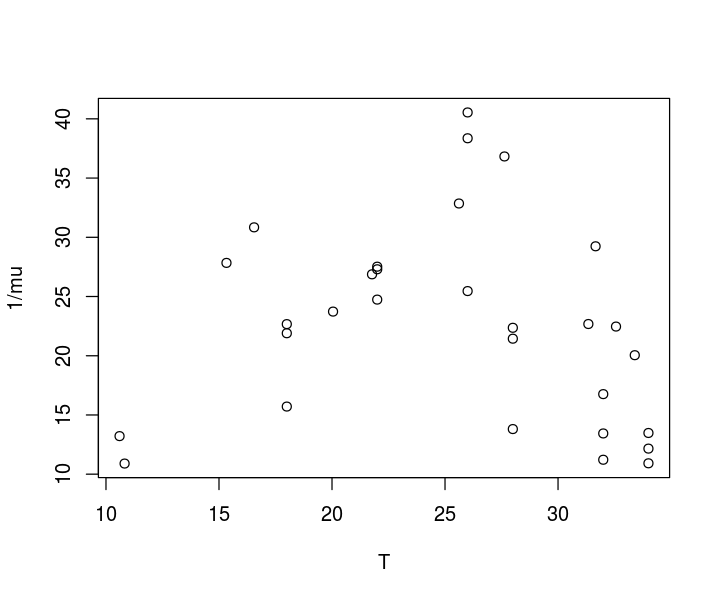

In [114]:
mu.data.inv <- mu.data # make a copy of the mu data
mu.data.inv$trait <- 1/mu.data$trait # take the inverse of the trait values to convert mu to lifespan
lf.data.comb <- rbind(mu.data.inv, lf.data) # combine both lifespan data sets together 
  
plot(trait ~ T, data = lf.data.comb, ylab="1/mu")

#### Two thermal performance curve models
Most thermal response curves can be reasonably fit using one of two thermal reponses. Traits that respond unimodally but symmetrically to temperature can be fit with a quadratic function:

$ q (T-T_0) (T-T_m)$  

Traits that respond unimodally but asymetrically can be fited with a Briere function:

$q T (T-T_0) \sqrt{T_m-T}$

In both models, $T_0$ is the lower thermal limit, $T_m$ is the upper thermal limit (i.e., where the trait value goes to zero on either end), and $q$ scales the elevation of the curve, (and so also the value at the optimum temperature).   


#### The thermal response model file
Unlike the previous bayesian \example, here we will provide jags with the model written as a `.txt` file. THis can be in your working directory, or elsewhere (but then inout the full path to it --- ideally a relative path). 

You can either write the text yourself directly to the file, or create it using the sink() function via your R script (see below):

Note that the model file `quad.txt` has two mandatory sections (the priors and the likelihood) and one optional section (derived measures calculated from your fitted parameters).

In the example below for a quadratic function, most of the priors are specified via uniform distributions (the two arguments specific the lower and upper bounds, respectively). Note that unlike in R and most other programs, in jags, the inverse of the variance of the normal distribution is used, denoted by $\tau (= \frac{1}{\sigma^2}$).  

The likelihood for can be interpreted as follows: the observed data are normally distributed where the mean at a given temperature follows the quadratic equation.

Now, prepare the data for jags: 

In [115]:
# Parameters to Estimate
parameters <- c("cf.q", "cf.T0", "cf.Tm","cf.sigma", "z.trait.mu.pred")

# Initial values for the parameters
inits<-function(){list(
  cf.q = 0.01,
  cf.Tm = 35,
  cf.T0 = 5,
  cf.sigma = rlnorm(1))}

# MCMC Settings: number of posterior dist elements = [(ni - nb) / nt ] * nc
ni <- 25000 # number of iterations in each chain
nb <- 5000 # number of 'burn in' iterations to discard
nt <- 8 # thinning rate - jags saves every nt iterations in each chain
nc <- 3 # number of chains

# Temperature sequence for derived quantity calculations
Temp.xs <- seq(0, 45, 0.2)
N.Temp.xs <-length(Temp.xs)

### Fitting the trait thermal response; Pull out data columns as vectors
data <- lf.data.comb # this lets us reuse the same generic code: we only change this first line
trait <- data$trait
N.obs <- length(trait)
temp <- data$T

# Bundle all data in a list for JAGS
jag.data<-list(trait = trait, N.obs = N.obs, temp = temp, Temp.xs = Temp.xs, N.Temp.xs = N.Temp.xs)

Now run the fitting using jags:

In [116]:
lf.fit <- jags(data=jag.data, inits=inits, parameters.to.save=parameters, 
               model.file="quad.txt", n.thin=nt, n.chains=nc, n.burnin=nb, 
               n.iter=ni, DIC=T, working.directory=getwd())

module glm loaded


Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 30
   Unobserved stochastic nodes: 4
   Total graph size: 2007

Initializing model



Change into "mcmc" type samples for visualization with the `coda` package:

In [117]:
lf.fit.mcmc <- as.mcmc(lf.fit)

#### Running diagnostics

View the parameters (only the first 5 lines, or it will also show you all of your derived quantities):

In [118]:
lf.fit$BUGSoutput$summary[1:5,]

,mean,sd,2.5%,25%,50%,75%,97.5%,Rhat,n.eff
cf.T0,6.4943265,2.09300384,1.60602110,5.24712819,6.7642097,7.960755,9.8890203,1.011800,450
cf.Tm,39.2489169,1.66643065,36.56998429,38.04932891,39.0173139,40.200410,43.1551656,1.004244,580
cf.q,0.1099374,0.02623226,0.06461983,0.09123192,0.1085517,0.126104,0.1657431,1.005886,440
cf.sigma,6.7100226,0.96797653,5.13196346,6.03242714,6.6036237,7.279794,8.9213322,1.001077,7200
deviance,197.7198535,3.09086985,193.77713702,195.42279657,197.0587314,199.288979,205.4720801,1.001325,3800


Plot the chains:

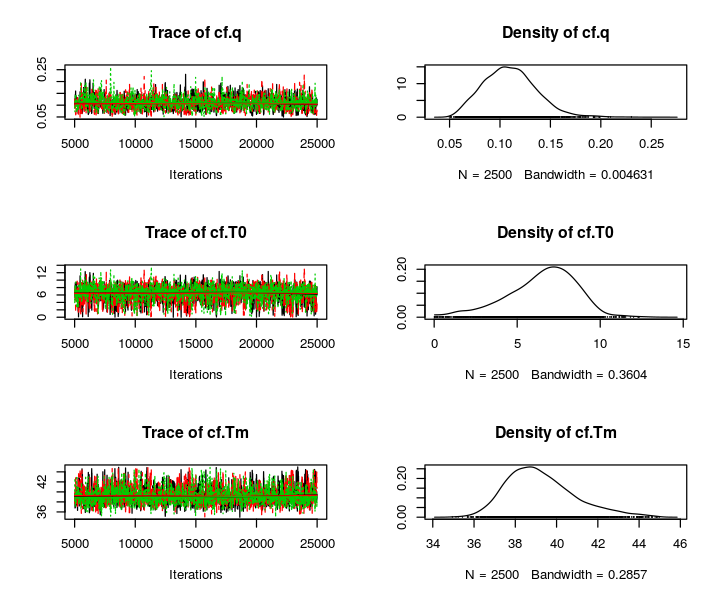

In [119]:
plot(lf.fit.mcmc[,c(1,3,4)])

#### Plot the fits

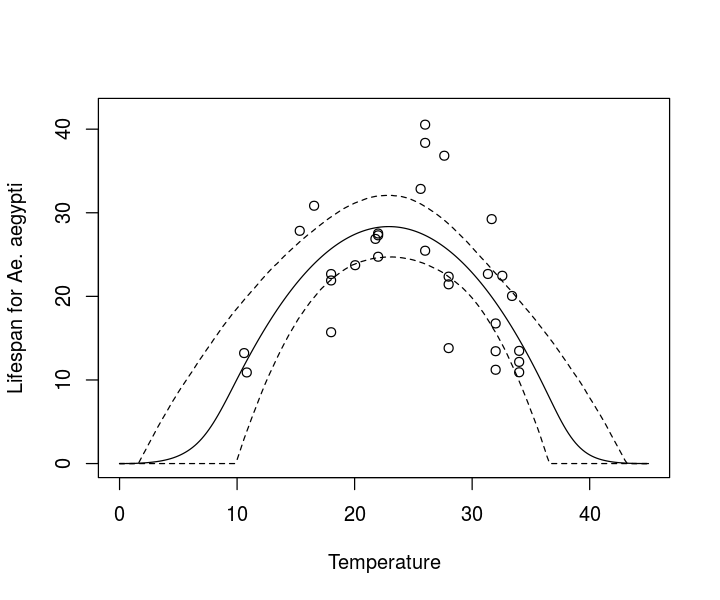

In [120]:
plot(trait ~ T, xlim = c(0, 45), ylim = c(0,42), data = lf.data.comb, ylab = "Lifespan for Ae. aegypti", xlab = "Temperature")
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "2.5%"] ~ Temp.xs, lty = 2)
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "97.5%"] ~ Temp.xs, lty = 2)
lines(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "mean"] ~ Temp.xs)

#### Additional analyses

You can use the `which.max()` function to find the optimal temperature for adult lifespan:

In [121]:
Temp.xs[which.max(as.vector(lf.fit$BUGSoutput$summary[6:(6 + N.Temp.xs - 1), "mean"]))]

[1] 23

You can also pull out the lifespan values for each iteration of the MCMC chain over the temperature gradient to calculate $R_0$:

In [122]:
lf.grad <- lf.fit$BUGSoutput$sims.list$z.trait.mu.pred
dim(lf.grad) # A matrix with 7500 iterations of the MCMC chains at 226 temperatures

[1] 7500  226

## The Traits Challenge

You will work in groups to tackle this "Challenge" problem. 

The main objective is to fit alternative models to data using Maximum Likelihood and compare/select between them. Your goal is not just to practise model fitting and selection, but also to extract biological insights from it. 

**_You will present the results of your analysis and biological inferences during the group discussion session_**. 

Good luck!
  
### The Data

The data for this question consist of thermal traits for *Aedes agypti* mosquitos found in the data file ` AeaegyptiTraitData.csv`. 

There are four possible traits (as well as some data that are recorded as the inverse trait, which we ignore for now):

- pEA: proportion surviving from egg to adulthood  
- MDR: mosquito development rate  
- PDR: parasite development rate (= 1/EIP the extrinsic incubation period)  
- $\mu$ (mu): death rate (= 1/longevity)

You will choose one of these four traits and fit a curve to the data using maximum likelihood. You may also fit  models to data of your choosing.

Base your code on what was provided in the lecture/practical portion of the class. You will start with a specific set of tasks to accomplish, starting with easy ones through to more challenging ones. 

First read in the data and look at the summary.

In [123]:
dat<-read.csv(file="../data/AeaegyptiTraitData.csv")
summary(dat)

 trait.name       T             trait         
 1/mu:18    Min.   : 1.00   Min.   : 0.00000  
 EIP :27    1st Qu.:20.00   1st Qu.: 0.03044  
 MDR :29    Median :26.67   Median : 0.13587  
 mu  :12    Mean   :26.41   Mean   : 5.14394  
 PDR :12    3rd Qu.:32.00   3rd Qu.: 6.00000  
 pEA :55    Max.   :52.00   Max.   :40.54000  
                                              
                                     ref          trait2    trait2.name 
 Eisen_et_al_2014                      :31   Karachi :  6   EIP50 :  4  
 Beserra_2009                          :18   Surabaya:  6   Strain: 18  
 Kamimura_et_al_2002_JapanSocMedEnt&Zoo:18   Timor   :  6   NA's  :131  
 Tun-Lin_et_al_2000_MedVetEnto         :13   NA's    :135               
 Rueda_et_al_1990_EntSocAm             :12                              
 Yang_et_al_2008_EpidInfect            :12                              
 (Other)                               :49                              

Nexts plot the response output, `trait` across temperature, `T`:

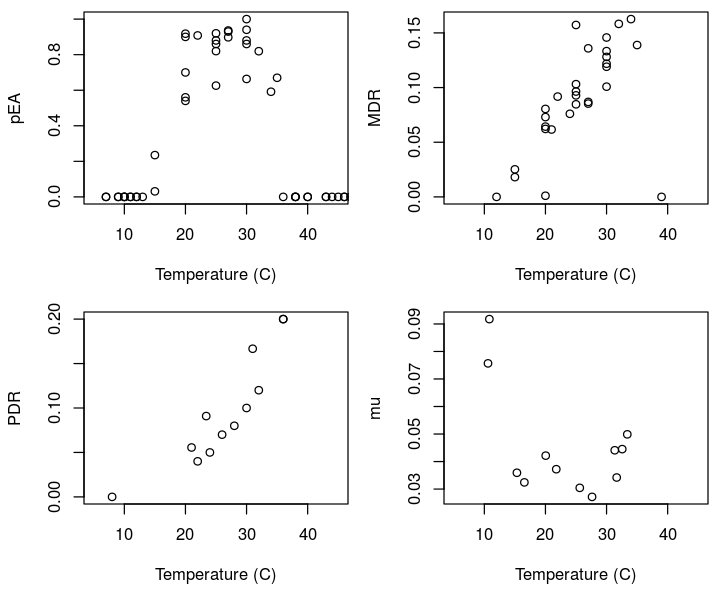

In [124]:
traits<-c("pEA", "MDR", "PDR", "mu")
par(mfrow=c(2,2), bty="o", mai=c(0.8,0.7,0.1,0.1))
for(i in 1:4){ 
    d.temp<-subset(dat, trait.name==traits[i])
    plot(trait ~ T, data=d.temp, xlab="Temperature (C)", ylab=traits[i], xlim=c(5, 45))
}

### Guidelines

We suggest the following steps for your analysis. 

**(1) Fitting a linear model, revisited**

* Using the [`nll.slr`](#Implementing-the-Likelihood-in-R) function and the code you wrote above, find the MLEs of the slope and intercept (i.e., find the best fitting line for your chosen trait). 
* Plot your data with the fitted line.
* Plot the likelihood surface for $b_0$ and $b_1$ and indicate the MLEs your likelihood surface. 
* Obtain confidence intervals for your estimates. 

**(2) Fitting a non-linear model**

* Choose a non-linear model to fit to your trait (e.g., the quadratic, Briere from [above](#Two-thermal-performance-curve-models)). We have implemented some functions in the file `temp_functions.R` that can be found in the `code` directory. 
* Using the [`nll.slr`](#Implementing-the-Likelihood-in-R) function as an example, write your own function that calculates the negative log likelihood as a function of the parameters describing your trait and any additional parameters you need for an appropriate noise distribution (e.g., $\sigma$ if you have normal noise).
* Use the `optim()` function to find the MLEs of all of your parameters.
* Obtain a confidence interval for your estimate.
* Plot the fitted function with the data and your fittend line from Task 1.
* Do all of these with a second (linear or non-linear) function fited to your trait data. Find the MLEs and fit this curve to your data. 
* Plot both the fits on the data.

**(3) Compare models**

Now compare your models (e.g., AIC, BIC, LRT). Optionally, also calculate the relative model probabilities). Which comes out on top? Is this what you expected? What biological inferences can you draw from the results?

**_Extra challenge_**

If you have the time and the interest you may try to fit curves to all of the 4 traits in the data!

## The *Extended* Traits Challenge

Perform a Bayesian analysis for the same *Aedes agypti* mosquito traut data in ` AeaegyptiTraitData.csv`. 

Here you will perform model selection with DIC, as explained in the Intro to Bayesian Stats [lecture]((https://github.com/vectorbite/VBiTraining/tree/master/lectures)).  

## Readings and Resources <a id='Readings'></a>

* Motulsky, Harvey, and Arthur Christopoulos. Fitting models to biological data using linear and nonlinear regression: a practical guide to curve fitting. OUP USA, 2004.
* Johnson, J. B. & Omland, K. S. 2004 Model selection in ecology and evolution. Trends Ecol. Evol. 19, 101–108.
* The [NCEAS non-linear modelling working group](https://groups.nceas.ucsb.edu/non-linear-modeling/projects/OrangeTree)
* Bolker, B. Ecological models and data in R. (Princeton University Press, 2008). 

**TODOs:**
* Switch traits MLE example to power law (allometry)
* Show worked example of model selection within the MLE framework
* Show worked example of model selection within the Bayesian framework 